## Udacity self driving car nanodegree
### Project: Vehicle Detection

In [30]:
# Import necessary modules
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
# NOTE: the next import is only valid for scikit-learn version >= 0.18
from sklearn.model_selection import train_test_split
# for scikit-learn <= 0.18 use:
#from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

### Util funtions
Following cell implements the general utility functions used elsewhere in the notebook. Most of the code written below is based on the lesson exercises.

In [31]:
def convert_color(img, color_space):
    """Apply color space conversions for an BGR image.
    Args:
        img: Input image ndarray.
        color_space: Color space. Supported values are
                    'RGB', 'HSV', 'LUV', 'HLS', 'YUV' and 'YCrCb'
    Returns:
        out_img: Output image.
    """    
    # apply color conversion if other than 'RBG'
    if color_space != 'BGR':
        if color_space == 'RGB':
            out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)               
        elif color_space == 'HSV':
            out_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            out_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            out_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            out_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            out_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: out_img = np.copy(img)
    
    return out_img

def ShowImages(im1, im2, title1, title2):
    """Show images.

    Show images using imshow

    Args:
        image: Input image.
        im1: Image 1
        im2: Image 2
        title1: Title for im1
        title2: Title for im2
    Returns:
        None
    """        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()
    ax1.set_title(title1)
    ax1.imshow(im1)
    ax2.set_title(title2)
    ax2.imshow(im2)

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draws bounding boxes on to an image.

    Args:
        img: Image.
        bboxes: Bounding boxes
    Optional args:
        color: color of the box
        thick: Thickness of the box
    Returns:
        draw_image: Image with bounding boxes.          
    """
    # Make a copy of the image
    draw_image = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_image, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_image

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Dataset exploration

In [32]:
def data_look(car_list, notcar_list):
    """Read a list of car and notcar image files and print stats.
    Args:
        car_list: List of image file names containing cars.
        notcar_list: List of image file names containing no cars.
    Returns:
        None.
    """    
    n_cars = len(car_list)
    n_notcars = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.cvtColor(cv2.imread(car_list[0]), cv2.COLOR_BGR2RGB)    
    image_shape = example_img.shape
    data_type = example_img.dtype
    
    print('Data set has ', n_cars, ' car images and ',n_notcars, ' non-car images')
    print('of size: ',image_shape, ' and data type:', data_type)

    # Plot random car/non-car images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_BGR2RGB)
    notcar_image = cv2.cvtColor(cv2.imread(notcars[notcar_ind]), cv2.COLOR_BGR2RGB)
    
    # Plot the examples
    ShowImages(car_image, notcar_image, 'Example car Image', 'Example notcar Image')

In [33]:
# Create list of car and notcar images
cars = [] # List of file names of images with car/vehicle
notcars = [] # List of file names images without car/vehicle

cars += glob.glob('../vehicles/**/*.png', recursive=True)
notcars += glob.glob('../non-vehicles/**/*.png', recursive=True)

Data set has  8792  car images and  8968  non-car images
of size:  (64, 64, 3)  and data type: uint8


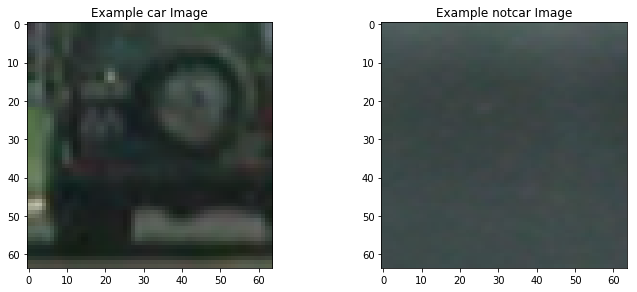

In [34]:
# Dump some stats about the data
data_look(cars, notcars)

#### Data exploration note:
The number of car images (8792) and non-car images (8968) are almost equal so there is no need to balance the dataset.

## Feature extraction
The following cells implement feature extraction functions. The code below is copied from lesson exercises.

In [19]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """Extracts Histogram of Oriented Gradients (HOG) for a given image.
    Args:
        img: Input image ndarray
        orient: Number of orientations
        pix_per_cell: Number of Pixels per cell
        cell_per_block: Number of cells per block
    Optional Args:
        vis: Visualize the result. Default: False
        feature_vec: Boolean to indicate if the output needs to be flattened. Default: False
    Returns:
        feature: HOG descriptor for the image. If feature_vector is True, a 1D (flattened) array is returned.
        hog_image: A visualisation of the HOG image. Only provided if visualize is True.
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """Extracts Binned color features.
    Args:
        img: Input image ndarray
    Optional Args:
        size: Default: (32, 32)
    Returns:
        features: Flattened 1D array of pixels after resizig the image.
    """    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Extracts color histogram features.
    Args:
        img: Input image ndarray.
    Optional Args:
        nbins: Number of histogram bins. Default: 32
        bins_range: Bins range. Default: (0, 256)
    Returns:
        features: Flattened 1D array of histograms.
    """
    # Compute the histogram of the color channels separately
    hist_features = []
    for channel in range(img.shape[2]):
        channel_hist = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
        hist_features.extend(channel_hist[0])
    return hist_features

In [26]:
class VehicleDetection:   
    def __init__(self):
        """Initializes the training of the vechicle detection.
        Args:
            None
        Returns:
            None.               
        """ 
        self.reset()
        
    def reset(self):    
        """Resets the training of the vechicle detection.
        
        Resets the parameters that control the feature extraction and training of the model used for vehicle detection.
        The values are based on the result of evaluation of different parameter config set.
            
        Args:
            None
        Returns:
            None.               
        """
        # Features
        self.color_space = 'LUV' # Can be RGB, RBG, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 12  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (16, 16) # Spatial binning dimensions
        self.hist_bins = 16 # Number of histogram bins
        self.spatial_feat = False # Spatial features on or off
        self.hist_feat = False # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        
        # Scaler
        self.X_scaler = StandardScaler() # Standard scaler from sklearn.preprocessing
        
        # Classifier function        
        self.svc = LinearSVC() # Linear SVC from sklearn.svm
        
        # Stats
        self.extract_time = 0 # Time taken to extract features
        self.feature_len = 0 # Length of the feature vector
        self.train_time = 0 # Time took for training
        self.accuracy = 0 # Accuracy of classification
        self.pred_time = 0 # Time taken for predicting 10 samples        
        
        print('color space: ', self.color_space)
        if (self.hog_feat == True):
            print('HOG Feature enabled')
            print('\t Number of orientations: ', self.orient)
            print('\t Pixels per cell: ', self.pix_per_cell)
            print('\t Cells per block: ', self.cell_per_block)
            print('\t Channels: ', self.hog_channel)
        if (self.spatial_feat == True):
            print('Spatial Feature enabled')
            print('\t Spatial size: ', self.spatial_size)
        if (self.hist_feat == True):
            print('Color Histogram Feature enabled')
            print('\t Hist bins: ', self.hist_bins)
        print('Using StandardScaler() for normalizing the features')    
        print('Using LinearSVC() as classifier function')
    
    def extract_features(self, imgs):
        """Extracts features from a list of image files.
        
        Extracts features from a list of image files.
        The files are read using cv2.imread()
        This function calls get_hog_features(), bin_spatial() and color_hist() to extract features.
        Args:
            imgs: List of image files.
        Returns:
            features: List of feature vectors (one per image).               
        """ 
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in imgs:
            file_features = []
            # Read in each one by one
            image = cv2.imread(file)
            
            # apply color conversion if other than 'BGR'
            feature_image = convert_color(image, self.color_space)

            # Extract spatial features    
            if self.spatial_feat == True:
                spatial_features = bin_spatial(feature_image, size=self.spatial_size)
                file_features.append(spatial_features)
            
            # Extract color histogram features
            if self.hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(feature_image, nbins=self.hist_bins)
                file_features.append(hist_features)
            
            # Extract histogram of gradiants
            if self.hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if self.hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            self.orient, self.pix_per_cell, self.cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], self.orient, 
                                self.pix_per_cell, self.cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            # Append the concatnated file_features
            features.append(np.concatenate(file_features))
        # Return list of feature vectors
        return features
    
    def train_classifier(self, cars, notcars):
        """Trains a classfier function to classify images containing cars.
        
        Trains an SVM classifier to detect images containing cars/vechicles.
        This function calls extract_features() to extract features.
        Args:
            cars: List of image files containing car/vehicles.
            notcars: List of image files containing non-car/vehicle road objects.
        Returns:
            features: List of feature vectors (one per image).          
        """
        t=time.time()
        # Extract features from car images
        car_features = self.extract_features(cars)
        
        # Extract features fromm notcar images
        notcar_features = self.extract_features(notcars)
       
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Store feature length
        self.feature_len = len(X[0])

        # Define the labels vector. 1 => Car, 0 => no Car
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets. Allocate 20% for testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Fit a per-column scaler
        self.X_scaler.fit(X_train)
        
        # Apply the scaler to X
        X_train = self.X_scaler.transform(X_train)
        X_test = self.X_scaler.transform(X_test)
        t2 = time.time()
        # Store feature extract/normalize time
        self.extract_time = round(t2 - t, 2)

        # Check the training time
        t=time.time()
        self.svc.fit(X_train, y_train)
        t2 = time.time()
        # Store training time
        self.train_time = round(t2-t, 2)

        # Store accuracy
        self.accuracy = round(self.svc.score(X_test, y_test), 4)

        # Check the prediction time for first 10 test samples
        t=time.time()
        self.svc.predict(X_test[0:10])
        t2 = time.time()
        self.pred_time = round(t2-t, 5)
        
        # Print stats
        print('SVC trained with ', len(X_train), 'images')
        print('Feature extract/normalize time: ', self.extract_time, ' secs')
        print('Train time: ', self.train_time, ' secs')
        print('Accuracy: ', self.accuracy)
        print('Prediction time for 10 samples: ', self.pred_time, ' secs')

    def find_cars(self, img, x_start_stop, y_start_stop, scale):
        """Finds cars in an image.
        
        Extracts HOG features using sub-sampling.
        Args:
            img: Input image.
            y_start_stop: start and stop co-ordinates in y axis
            scale: Window scaling
        Returns:
            bboxes: List of bounding box around detected cars.          
        """        
        xstart = x_start_stop[0]
        xstop = x_start_stop[1]

        ystart = y_start_stop[0]
        ystop = y_start_stop[1]
        
        # Set search area
        img_tosearch = img[ystart:ystop,xstart:xstop,:]
        
        # Convert to specified color space
        ctrans_tosearch = convert_color(img_tosearch, self.color_space)
        
        if scale != 1:
            # Resize the search area
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # Extract individual channels
        if (self.hog_channel == 'ALL'):
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]
        else:
            ch1 = ctrans_tosearch[:,:,self.hog_channel]

        # Define blocks and steps
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient*self.cell_per_block**2

        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        cells_per_step = 1  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
      
        # Compute individual channel HOG features for the entire image
        if (self.hog_channel == 'ALL'):      
            hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        else:
            hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

        bboxes = []        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                features = []
                
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                if (self.spatial_feat == True) or (self.hist_feat == True):                
                    # Extract the image patch for color features
                    subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                if (self.spatial_feat == True):
                    # Get color spatial features
                    spatial_features = bin_spatial(subimg, size=self.spatial_size)
                    features.extend(spatial_features)

                if (self.hist_feat == True):
                    # Get color hist features
                    hist_features = color_hist(subimg, nbins=self.hist_bins)
                    features.extend(hist_features)
                               
                if (self.hog_feat == True):
                    # Extract HOG for this patch
                    if self.hog_channel == 'ALL':
                        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                    else:
                        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                        hog_features = hog_feat1
                        
                    features.extend(hog_features)

                # Normalize features and make a prediction
                features = np.asarray(features, np.float64)
                features = features.reshape(1, -1)
                test_features = self.X_scaler.transform(features)    
                test_prediction = self.svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bboxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
        
        # Return the bounding boxes
        return bboxes

In [21]:
# Create a VehicleDetectionTrainer class
car_detect = VehicleDetection()  

Trainer reset
color space:  LUV
HOG Feature enabled
	 Number of orientations:  12
	 Pixels per cell:  8
	 Cells per block:  2
	 Channels:  ALL
Using StandardScaler() for normalizing the features
Using LinearSVC() as classifier function


In [22]:
# Train the classifier with pre-determined parameters
car_detect.train_classifier(cars, notcars)

SVC trained with  14208 images
Feature extract/normalize time:  117.59  secs
Train time:  27.79  secs
Accuracy:  0.971
Prediction time for 10 samples:  0.0005  secs


In [28]:
def process_image(img, debug=False):
    bboxes = []
    x_start_stop = [0, 1280]

    # Nearest to camera
    y_start_stop = [500, 700]
    scale = (y_start_stop[1] - y_start_stop[0])/64 # Assuming exactly one car fits in the window 
    bboxes.extend(car_detect.find_cars(image, x_start_stop, y_start_stop, scale))    

    # intermediate  
    y_start_stop = [550, 670]
    scale = (y_start_stop[1] - y_start_stop[0])/64 # Assuming exactly one car fits in the window 
    bboxes.extend(car_detect.find_cars(image, x_start_stop, y_start_stop, scale))    
    
    # intermediate
    y_start_stop = [480, 550]
    scale = (y_start_stop[1] - y_start_stop[0])/64 # Assuming exactly one car fits in the window 
    bboxes.extend(car_detect.find_cars(image, x_start_stop, y_start_stop, scale))    

    # intermediate
    y_start_stop = [400, 450]
    scale = (y_start_stop[1] - y_start_stop[0])/64 # Assuming exactly one car fits in the window 
    bboxes.extend(car_detect.find_cars(image, x_start_stop, y_start_stop, scale))    
    
    # Farthest from camera (horizon)
    y_start_stop = [380, 420]
    scale = (y_start_stop[1] - y_start_stop[0])/64 # Assuming exactly one car fits in the window 
    bboxes.extend(car_detect.find_cars(image, x_start_stop, y_start_stop, scale))    

    # Heatmap
    heat_img = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat_img = add_heat(heat_img, bboxes)
    # Apply threshold to help remove false positives
    heat_img = apply_threshold(heat_img,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_img, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if debug == True:
        draw_image_all = draw_boxes(np.copy(image), bboxes)
        # Return output image and heatmap
        return draw_img, draw_image_all, heatmap        
    else:
        # Return output image
        return draw_img

Processed image in  1.15  secs


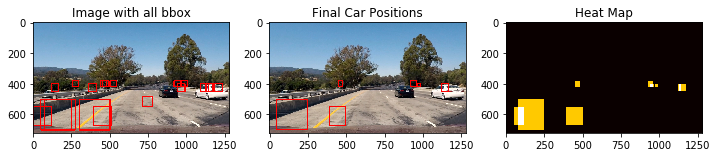

In [29]:
# Test with an image
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/test1.jpg')

# Process image
t=time.time()
draw_img, draw_img_all, heatmap = process_image(image, debug=True)
t2=time.time()
print('Processed image in ', round(t2-t, 2), ' secs')
fig = plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(cv2.cvtColor(draw_img_all, cv2.COLOR_BGR2RGB))
plt.title('Image with all bbox')
plt.subplot(132)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title('Final Car Positions')
plt.subplot(133)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [ ]:
test_images = glob.glob('../CarND-Advanced-Lane-Lines/test_images/*.jpg')
n = len(test_images)
f, axes = plt.subplots(n, 1, figsize=(5, 5*n))
for i in range(n):
    image = cv2.imread(test_images[i])
    draw_img = process_image(image)
    axes[i].set_title('image' + str(i))   
    axes[i].imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))